<a href="https://colab.research.google.com/github/yamada-github-account/LearnBayesNN/blob/master/JointDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

%matplotlib inline

(<tf.Tensor: shape=(), dtype=float32, numpy=24.326206>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.6130161>,
 <tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([108.08908  ,  55.634426 ,   5.9656234, 107.91572  ,  22.117992 ,
         18.21659  ,  92.68158  ,  53.118675 , 117.99356  ,  11.869347 ,
        111.37376  ,  73.952736 ,  20.325335 , 111.87221  ,  67.547005 ,
         64.81824  ,  94.39402  , 110.142105 ,  91.44482  ,   5.3255258,
         78.146065 ,  39.434807 , 114.22096  , 115.102936 ,  50.97116  ,
        119.26938  ,  72.486946 ,  85.14754  , 116.80966  ,  34.386707 ],
       dtype=float32)>)

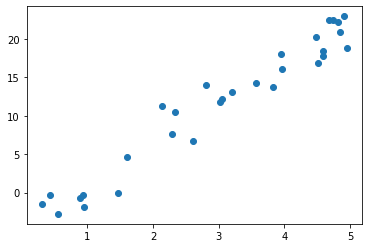

In [2]:
# https://www.hellocybernetics.tech/entry/2019/10/13/220834

# テストデータ生成
def toy_data():
    x = np.random.uniform(0, 5, 30)
    y = 5 * x - 3 + np.random.normal(0, 2, 30)
    return x, y
x_np, y_np = toy_data()

plt.plot(x_np, y_np, "o")


# 変数を Tensor に
x = tf.convert_to_tensor(
    x_np,
    dtype=tf.float32
)

y = tf.convert_to_tensor(
    y_np,
    dtype=tf.float32
)

# 同時分布をコルーティンで記述
# TODO: うまく x を渡せずに、グローバル変数として参照してしまっている。要改善
Root = tfd.JointDistributionCoroutine.Root
def model():
    a = yield Root(tfd.Normal(loc=0, scale=10.))
    b = yield Root(tfd.Normal(loc=0, scale=10.))
    y = yield tfd.Normal(loc=a * x + b, scale=tf.constant(2.0)) # 最後だけRootが不要？


joint = tfd.JointDistributionCoroutine(model)

joint.sample() # yield した順の a, b, y に対応する Tensor が入っている。 どうして、y だけ、こんなに数多くサンプリングされている？？？

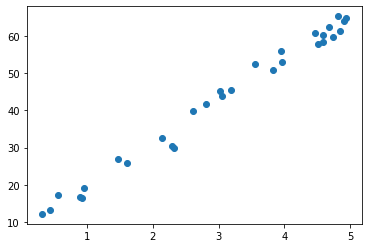

In [3]:
plt.plot(x.numpy(), joint.sample()[-1].numpy(), "o")

In [4]:
# TODO: うまく y を渡せずに、グローバル変数として参照してしまっている。要改善
def unnormalized_log_posterior(a, b):
    return tf.reduce_mean(joint.log_prob([a, b, y]))

In [5]:
# 勾配ベースで計算をするメトロポリスヘイスティング法の発展版NUTS
kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=unnormalized_log_posterior,
      step_size=0.1,
)

In [6]:
# tf.function でデコレートしておかないと遅いらしい
@tf.function()
def run_chain():
    init_state = list(joint.sample()[:-1]) # a, b
    chains_states, kernels_results = tfp.mcmc.sample_chain(
        num_results=1000,
        num_burnin_steps=300,
        current_state=init_state,
        kernel=kernel
    )
    return chains_states, kernels_results

# Sample from posterior distribution and get diagnostic
chain_states, kernel_results = run_chain()

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


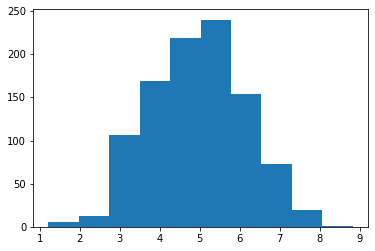

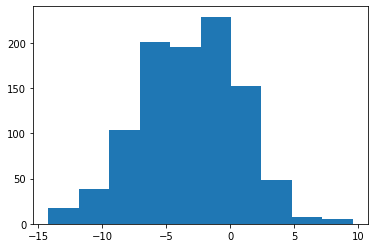

In [7]:
a = chain_states[0]
b = chain_states[1]

# a
plt.hist(a)
plt.show()

# b
plt.hist(b)
plt.show()

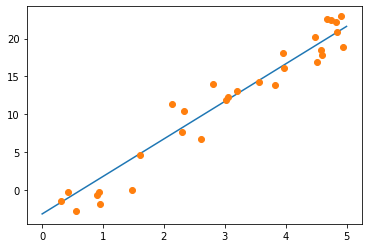

In [8]:
# EAP推定 (分布の平均値の利用)

x_ = tf.convert_to_tensor(np.linspace(0,5,100), dtype=tf.float32)
y_ = tf.reduce_mean(a) * x_ + tf.reduce_mean(b)

plt.plot(x_,y_)
plt.plot(x,y,"o")

In [9]:
samples_ = tfd.Normal(loc=tf.expand_dims(a, axis=0) * tf.expand_dims(x_, axis=1) + tf.expand_dims(b, axis=0),scale=2.0).sample()

In [10]:
y_expected = tf.reduce_mean(samples_, axis=1)

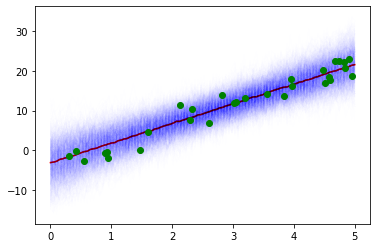

In [11]:
plt.plot(x_, y_expected, "r")
plt.plot(x_, samples_, "b", alpha=0.003 )
plt.plot(x, y, "og")